# Pneumonia Detection from X-Ray images

## Introduction

- Objective: Detect pneumonia from X-Ray images using Machine Learning
- Datasets: Train, Validation and Test sets of JPEG images

The objective of this project is to develop a Machine Learning model to detect pneumonia from X-Ray images.

We will use these 3 datasets: Train, Validation and Test. 

Each containing JPEG images categorized as either normal or pneumonia-affected. 

The following steps outline our approach to achieve this goal.

# Import necessary libraries

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# Define the directories for the datasets

In [52]:
base_dir = "../chest_Xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Initialize ImageDataGenerator for data augmentation
### (ImageDataGenerator is a class of Keras API for generating batches of image data with realtime data augmentation.)

In [53]:
"""
/train_datagen/
rescale: rescale image pixel values from a range of [0, 255] to [0, 1]
common practice to normalize pixel values for neural network inputs to improve convergence

flip: flip image horizontally. Useful for augmenting image data because it creates new examples from existing images


/val_test_datagen/
scale the pixel values from [0, 255] to [0, 1]. 
No other augmentations are applied to validation and test data because these datasets should represent the true distribution of the data
we want to evaluate our model on unaltered images.
"""
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [54]:
"""
Create data generators
flow_from_directory is a method provided by the ImageDataGenerator class to read images from a directory and generate batches of augmented data.

target_size: resize all images to 150x150 pixels
batch_size: return batches of 32 images
class_mode='binary': classes are binary, two classes ('Pneumonia' and 'Normal')
"""
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [55]:
# Display class indices
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


# Visualize Sample Images

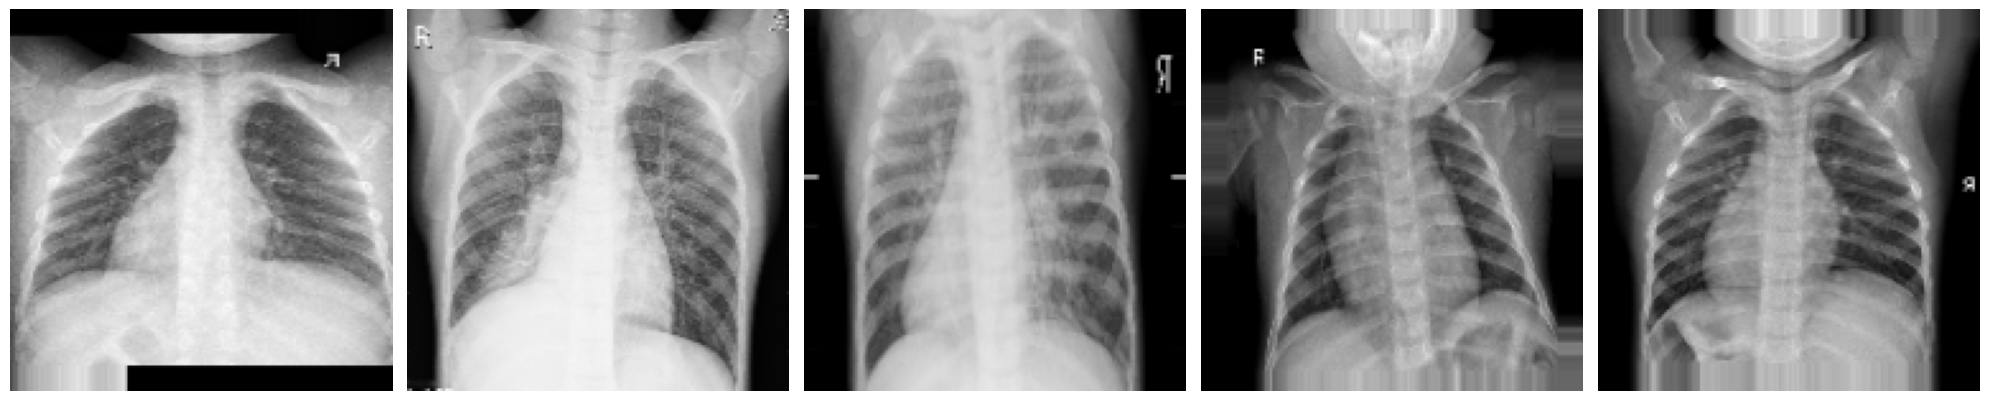

In [56]:
"""
A plot is a graphical representation of data. In the context of Matplotlib:
- Plots can display data in various forms such as line charts, bar charts, images, etc.
"""
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch of images
sample_training_images, _ = next(train_generator)

# Plot the images
plot_images(sample_training_images[:5])

In [57]:
# ImageDataGenerator for preprocessing (normalization)

